## 🎙 The VITS / Piper Architecture — A Unified Generative Model for Speech

Piper’s training pipeline is based on **VITS** (*Variational Inference with Adversarial Learning for End-to-End Text-to-Speech*) — see the original paper:  
[**Kim, Lee, et al. (2021). VITS: Conditional Variational Auto‐Encoder with Adversarial Learning for End‐to‐End Text-to-Speech**](https://arxiv.org/abs/2106.06103) and the model docs at HuggingFace: [**VITS**](https://huggingface.co/docs/transformers/v4.57.1/model_doc/vits)

---
### 🔧 Core Components and Their Roles



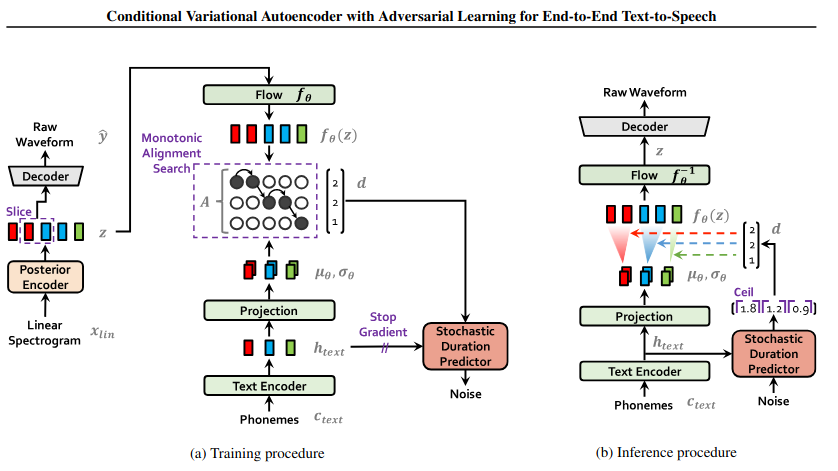



| Module | Conceptual Role | Model Structure | Mathematical Function |
|--------|------------------|------------------|------------------------|
| **Text Encoder (`enc_p`)** | Transformer mapping phonemes → latent *prior* distribution | Embedding → Multi-head self-attention → FFN | $$ p_\theta(z \mid x_{\text{text}}) $$ |
| **Posterior Encoder (`enc_q`)** | Maps real audio → latent *posterior* distribution | Conv1D residual stack (WaveNet-style) | $$ q_\phi(z \mid x_{\text{audio}}) $$ |
| **Flow ($f_\psi$)** | Aligns prior/posterior latent spaces via invertible mapping | Residual coupling layers + flips | Learns $$ z_p = f_\psi(z_q) $$ to minimize $$ D_{KL}(q\,||\,p) $$ |
| **Duration Predictor (`dp`)** | Predicts phoneme durations for prosody modeling | 1-D CNN with noise input | Controls timing of latent → waveform |
| **Decoder (`dec`)** | Generates waveform from latent $ z $ | HiFi-GAN–style upsampling network | $$ \hat x_{\text{audio}} = G_\omega(z) $$ |
| **Discriminator (`model_d`)** | Adversarial critic for perceptual audio quality | Multi-period & multi-scale CNNs | Optimises GAN loss + feature-matching |

---

### ⚙️ Training Flow

1. **Text Encoder** produces latent prior from phoneme input.  
2. **Posterior Encoder** infers latent from mel-spectrograms of real audio.  
3. **Flow** aligns the two latent distributions via KL divergence loss.  
4. **Decoder** reconstructs waveforms from latent variables.  
5. **Discriminator** gives adversarial and feature-matching feedback for high-fidelity audio.

---

### 🔁 Inference (Text → Speech)

At synthesis time:

$$
\text{Text} \;\xrightarrow{\text{enc}_p}\; p_\theta(z\mid x_{\text{text}})
\;\xrightarrow{f_\psi^{-1}}\; z
\;\xrightarrow{\text{dec}}\; \hat x_{\text{audio}}
$$

- The **posterior encoder** and discriminator are bypassed.  
- The **flow inverse** transforms a text-based latent into a “real-speech” latent before decoding.  
- The **decoder** outputs waveform directly.

---

### 🎓 Statistical Machine Learning Perspectives

- **VAEs:** latent encoding via $ q(z|x) $ and KL regularisation.  
- **Normalising Flows:** invertible latent transformations for flexible distributions.  
- **Transformers:** sequence modeling of phoneme context and linguistic embedding.  
- **GANs (Adversarial Feedback):** patch-level discriminator akin to image-GAN critics.

VITS integrates these in a single model, replacing older two-stage TTS pipelines (e.g., Tacotron + vocoder) with an *end-to-end latent-variable generative model* trained by both likelihood and adversarial objectives.

---



# 🗣️ Piper Voice Fine-Tuning Playground

This notebook provides an interactive environment for **experimenting with retraining and fine-tuning [Piper](https://github.com/rhasspy/piper)** text-to-speech (TTS) voices.

You can:
- Upload and a custom dataset of short audio clips and transcripts (`metadata.csv`, `wav/`) (We will provide subsamples fro the LJVoice research voce dataset, or you can use piper-audio-studio to record your own)
- Select an appropriate (or not!) base voice to finetune
- Resume training from an existing base checkpoint or a previous run
- Export the trained voice model to ONNX for fast inference
- Generate and listen to sample audio directly in Colab
- Save and restore training runs to continue fine-tuning later

The notebook is structured to work end-to-end on Google Colab’s GPU instances (T4, L4, or A100), but it can also run on local machines with sufficient VRAM.  

> 🧪 **Goal:** explore how training duration, dataset quality, and base checkpoints affect the resulting synthetic voice quality.



# Folder and Drive setup - data and code unzipping
This cell needs to be run at the beginning of any training session, and reconnect. It will remount your Google Drive, put the symlinks back in the filesystem, and unzip the compiled piper1-gpl code tree, as well as any audio voice datasets in place. If you run this without code or
datasets, it will create a top level folder in your Drive named "piper_experiments". Copy the provided "piper1-gpl.zip" into that folder, and any audio dataset zips into the "datasets" folder, then run this cell again.

## NB: Why ZIPS?
This seems to do a lot of work by unzipping (and later zipping) trees of files. The GDrive access from inside colab is via a FUSE network filesystem. Performance for many small directory and file reads is abysmal. Streaming a large zip, on the other hand, is decently fast. In the cell below that unpacks the compiled piper1-gpl tree, copying the full unpacked tree from GDrive took over 15 minutes, while streaming and unpacking the zip takes < 5 seconds.

This is also the reason we do not simply leave the data and run files on GDrive and use them directly there: fitting suffers from the same I/O induced bottlenecks.

In [1]:
# this was required for my code to run, otherwise torchaudio and speechbrain had a conflict
!pip install speechbrain

import torchaudio

# patch torchaudio so SpeechBrain doesn't break
if not hasattr(torchaudio, "list_audio_backends"):
    torchaudio.list_audio_backends = lambda: ["sox_io"]

from speechbrain.pretrained import EncoderClassifier

In [3]:
# @title
# 🗂️ Mount Google Drive + unified extraction for datasets and runs
from google.colab import drive
from pathlib import Path
import os, zipfile, shutil, json
from datetime import datetime, UTC

# ---------- Config ----------
MOUNT_DRIVE = True
BASE_LOCAL   = Path("/content/piper_experiments")
DATASETS_SUB = "datasets"
RUNS_SUB     = "runs"
PERSIST_SUBS = ("voices", "exports")   # keep these as symlinks to Drive

# ---------- Helpers ----------
def get_top_level_dirs(zip_path: Path):
    """Return set of top-level names (first path component) in a zip."""
    with zipfile.ZipFile(zip_path, "r") as zf:
        return {Path(n).parts[0] for n in zf.namelist() if "/" in n}

def _marker_path(target_dir: Path) -> Path:
    return target_dir / ".unzipped_from.json"

def _read_marker(target_dir: Path):
    try:
        with open(_marker_path(target_dir), "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception:
        return None

def _write_marker(target_dir: Path, zip_path: Path):
    meta = {
        "zip_name": zip_path.name,
        "zip_mtime": zip_path.stat().st_mtime,
        "timestamp": datetime.now(UTC).isoformat() + "Z",
    }
    with open(_marker_path(target_dir), "w", encoding="utf-8") as f:
        json.dump(meta, f)

def _latest_mtime(folder: Path) -> float:
    latest = folder.stat().st_mtime
    for root, dirs, files in os.walk(folder):
        dirs[:] = [d for d in dirs if not d.startswith(".") and d != "__pycache__"]
        for fn in files:
            if fn.startswith("."):
                continue
            try:
                mt = (Path(root) / fn).stat().st_mtime
                if mt > latest:
                    latest = mt
            except FileNotFoundError:
                pass
    return latest

def extract_zip_clean(zip_path: Path, target_dir: Path):
    """
    Safely extract a zip so that target_dir is the final folder,
    flattening a single top-level folder if present.
    """
    with zipfile.ZipFile(zip_path, "r") as zf:
        top_dirs = get_top_level_dirs(zip_path)
        if len(top_dirs) == 1:
            top = next(iter(top_dirs))
            print(f"📂 {zip_path.name}: has top folder '{top}' → extracting to {target_dir.parent}")
            zf.extractall(target_dir.parent)
            inner = target_dir.parent / top
            # Only rename if it's a different path
            if inner.resolve() != target_dir.resolve():
                if target_dir.exists():
                    shutil.rmtree(target_dir)
                inner.rename(target_dir)
            else:
                print("ℹ️  Zip’s top folder name matches target; no rename needed.")
        else:
            print(f"📦 {zip_path.name}: flat archive → extracting directly to {target_dir}")
            if target_dir.exists():
                shutil.rmtree(target_dir)
            target_dir.mkdir(parents=True, exist_ok=True)
            zf.extractall(target_dir)
    _write_marker(target_dir, zip_path)
    print(f"✅ Extracted {zip_path.name} → {target_dir}")

def sync_zip_folders(drive_dir: Path, local_dir: Path, label: str, pattern: str="*.zip", update_if_newer: bool=True):
    """
    Extract all zips matching `pattern` from drive_dir into local_dir.
    If the local target exists:
      - If `update_if_newer` and Drive zip has newer mtime than marker, re-extract.
      - Otherwise, skip.
    """
    drive_dir.mkdir(parents=True, exist_ok=True)
    local_dir.mkdir(parents=True, exist_ok=True)

    zips = sorted(drive_dir.glob(pattern))
    if not zips:
        print(f"ℹ️ No {label} zips found in {drive_dir}")
        return

    print(f"\n🧩 Found {len(zips)} {label} zip(s) in {drive_dir}:")
    for zpath in zips:
        # Decide target folder name
        top_dirs = get_top_level_dirs(zpath)
        folder_name = next(iter(top_dirs)) if len(top_dirs) == 1 else zpath.stem
        target_dir = local_dir / folder_name

        if target_dir.exists():
            if update_if_newer:
                marker = _read_marker(target_dir)
                drive_mtime = zpath.stat().st_mtime
                marker_mtime = marker.get("zip_mtime") if marker else None
                if (marker is None) or (drive_mtime > (marker_mtime or 0)):
                    print(f"🔁 {folder_name}: Drive zip is newer → re-extracting")
                    extract_zip_clean(zpath, target_dir)
                else:
                    print(f"✅ {folder_name}: up-to-date (from {marker.get('zip_name','?')})")
            else:
                print(f"✅ {folder_name}: already extracted → {target_dir}")
        else:
            print(f"📦 Extracting {zpath.name} → {target_dir}")
            extract_zip_clean(zpath, target_dir)



def save_run_to_drive(run_name: str, runs_local: Path, runs_drive: Path):
    """
    Zip a local run folder and copy to Drive runs dir.
    - overwrite=True replaces existing {run_name}.zip
    - timestamp=True writes {run_name}_YYYYMMDD-HHMMSS.zip
    """
    src = runs_local / run_name
    if not src.exists():
        raise FileNotFoundError(f"Run folder not found: {src}")

    tmp_dir = Path("/content/tmp_zips")
    tmp_dir.mkdir(exist_ok=True)

    runs_drive.mkdir(parents=True, exist_ok=True)
    dest_zip = runs_drive / f"{run_name}.zip"

    print(f"📦 Archiving run '{run_name}' → {dest_zip.name}")

    tmp_zip = tmp_dir / f"{run_name}.zip"
    print(f"📦 Creating local archive for {run_name} → {tmp_zip}")
    shutil.make_archive(
        str(tmp_zip.with_suffix("")),
        "zip",
        root_dir=runs_local,
        base_dir=run_name,
    )

    print(f"🚚 Moving archive to Drive → {dest_zip}")
    shutil.move(str(tmp_zip), str(dest_zip))
    return dest_zip


def save_updated_runs(local_runs: Path, drive_runs: Path):
    drive_runs.mkdir(parents=True, exist_ok=True)
    tmp_dir = Path("/content/tmp_zips")
    tmp_dir.mkdir(exist_ok=True)
    updated = []

    for run_dir in sorted(local_runs.glob("*")):
        if not run_dir.is_dir() or run_dir.name.startswith("."):
            continue
        run_name = run_dir.name
        dest_zip = drive_runs / f"{run_name}.zip"
        marker = _read_marker(run_dir)
        marker_ts = marker.get("timestamp") if marker else None
        marker_mtime = (
            _marker_path(run_dir).stat().st_mtime if _marker_path(run_dir).exists() else 0
        )

        if (run_dir / ".ipynb_checkpoints").exists():
            shutil.rmtree(run_dir / ".ipynb_checkpoints", ignore_errors=True)

        # latest mtime among files
        local_latest = _latest_mtime(run_dir)

        # update if no zip, or any file newer than marker
        needs_update = (
            not dest_zip.exists()
            or local_latest > marker_mtime + 1   # any newer local change
        )

        if not needs_update:
            print(f"✅ {run_name}: up-to-date (since {marker_ts})")
            continue

        dest_zip = save_run_to_drive(run_name, local_runs, drive_runs)
        _write_marker(run_dir, dest_zip)
        updated.append(run_name)

    if updated:
        print(f"🎉 Archived {len(updated)} updated run(s): {', '.join(updated)}")
    else:
        print("ℹ️ All run folders are already up-to-date.")



# ---------- Mount Drive ----------
if MOUNT_DRIVE:
    mount_path = Path("/content/drive")
    if not mount_path.is_mount():
        drive.mount(str(mount_path))
        print("✅ Google Drive mounted.")
    else:
        print("ℹ️  Google Drive already mounted.")
    drive_root = mount_path / "MyDrive" / "piper_experiments"
    drive_root.mkdir(parents=True, exist_ok=True)
else:
    drive_root = Path("/content/fake_drive"); drive_root.mkdir(parents=True, exist_ok=True)
    print("⚠️ Skipping Drive mount; using local only.")

# ---------- Local workspace ----------
BASE_LOCAL.mkdir(parents=True, exist_ok=True)

# Keep voices/exports as symlinks to Drive; datasets/runs live locally (unzipped)
for sub in PERSIST_SUBS:
    src = drive_root / sub
    src.mkdir(parents=True, exist_ok=True)
    dest = BASE_LOCAL / sub
    if dest.exists() or dest.is_symlink():
        dest.unlink()
    os.symlink(src, dest, target_is_directory=True)
    print(f"🔗 Linked {dest} → {src}")

datasets_dir = BASE_LOCAL / DATASETS_SUB
runs_dir     = BASE_LOCAL / RUNS_SUB
print(f"📁 Local datasets: {datasets_dir}")
print(f"📁 Local runs:     {runs_dir}")

# ---------- Sync zips from Drive → local ----------
sync_zip_folders(drive_root / DATASETS_SUB, datasets_dir, "dataset")
sync_zip_folders(drive_root / RUNS_SUB,     runs_dir,     "run")

print("\n✅ Environment ready.")
print(f"Local workdir: {BASE_LOCAL}")
print(f"Persistent dirs linked from Drive: {', '.join(PERSIST_SUBS)}")
print(f"Datasets extracted to: {datasets_dir}")
print(f"Runs extracted to:     {runs_dir}")


ℹ️  Google Drive already mounted.
🔗 Linked /content/piper_experiments/voices → /content/drive/MyDrive/piper_experiments/voices
🔗 Linked /content/piper_experiments/exports → /content/drive/MyDrive/piper_experiments/exports
📁 Local datasets: /content/piper_experiments/datasets
📁 Local runs:     /content/piper_experiments/runs

🧩 Found 2 dataset zip(s) in /content/drive/MyDrive/piper_experiments/datasets:
✅ ljs_short_dataset: up-to-date (from ljs_short_dataset.zip)
✅ ross_samples: up-to-date (from ross_dataset.zip)
ℹ️ No run zips found in /content/drive/MyDrive/piper_experiments/runs

✅ Environment ready.
Local workdir: /content/piper_experiments
Persistent dirs linked from Drive: voices, exports
Datasets extracted to: /content/piper_experiments/datasets
Runs extracted to:     /content/piper_experiments/runs


# piper code setup
 Run the following cell for each fresh session. This will either unpack a previously built piper tree (from a zip file in your GDrive), or fetch and build it. Building will take 3-5 minutes.
# NOTE

 you may see a popup complaining about reinstallation of a library (_distutils_hack) if building is necessary: it is safe to cancel this pop up and not restart the runtime.

In [4]:
# @title
import os, sys, shutil, zipfile
import zipfile, shutil
from datetime import datetime
from pathlib import Path
from google.colab import drive

# === CONFIG ===
repo_url = "https://github.com/OHF-voice/piper1-gpl.git"
local_repo = Path("/content/piper1-gpl")
drive_mount = Path("/content/drive")
drive_dir = drive_mount / "MyDrive" / "piper_experiments"


def prepare_piper_from_drive_zip(drive_root: Path, dest: Path = Path("/content/piper1-gpl")):
    def get_top_level_dirs(zip_path: Path):
        with zipfile.ZipFile(zip_path, "r") as zf:
            return {Path(n).parts[0] for n in zf.namelist() if "/" in n}

    root_drive = drive_root.parent  # .../MyDrive
    candidates = sorted(list(drive_root.glob("piper1-gpl*.zip")) + list(root_drive.glob("piper1-gpl*.zip")))
    if not candidates:
        print("ℹ️ No piper1-gpl zip found in Drive; will fall back to clone/build.")
        return False

    zpath = candidates[0]
    print(f"📦 Using {zpath.name} for piper1-gpl")
    if dest.exists():
        shutil.rmtree(dest)

    with zipfile.ZipFile(zpath, "r") as zf:
        top_dirs = get_top_level_dirs(zpath)
        if len(top_dirs) == 1:
            top = next(iter(top_dirs))
            zf.extractall("/content")
            inner = Path("/content") / top
            inner.rename(dest)
        else:
            dest.mkdir(parents=True, exist_ok=True)
            zf.extractall(dest)
    print(f"✅ Ready: {dest}")
    return True

# --- Mount Google Drive ---
if not drive_mount.is_mount():
    drive.mount(str(drive_mount))
    print("✅ Google Drive mounted.")
else:
    print("ℹ️  Google Drive already mounted.")

prepared = prepare_piper_from_drive_zip(Path(drive_dir), local_repo)
# --- Determine build or setup path ---
if prepared:
    print(f"📂 Found existing prebuilt Piper at {local_repo}")

    # ✅ Lightweight runtime-only setup
    print("⚙️ Installing runtime dependencies (espeak-ng only) ...")
    !apt-get update -qq && apt-get install -y espeak-ng espeak-ng-data
    !pip install pip setuptools wheel
    !pip install speechbrain

    %cd {local_repo}
    print("⚙️ Installing in editable (dev) mode ...")
    !pip install -e .[train]

    print("✅ Using prebuilt Piper copy — no build tools or rebuild needed.")

else:
    print("⬇️ No local repo found — performing full build and packaging ...")

    # 🧰 Full build dependencies (only when needed)
    print("⚙️ Installing full system build toolchain ...")
    !apt-get update -qq && apt-get install -y build-essential cmake git espeak-ng espeak-ng-data libespeak-ng-dev ninja-build
    !pip install -U pip setuptools wheel
    !pip install -U scikit-build cmake ninja speechbrain

    # --- Clone and build from source ---
    !git clone {repo_url}
    %cd {local_repo}

    print("⚙️ Installing in editable mode ...")
    !pip install -e .[train]

    print("🧱 Building C/C++ extensions (first-time build) ...")
    !./build_monotonic_align.sh
    !python3 setup.py build_ext --inplace

    # --- Archive for Drive reuse ---
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    zip_path = drive_dir / f"piper1-gpl_{ts}.zip"
    print(f"📦 Archiving build to {zip_path.name} ...")
    shutil.make_archive(str(zip_path).replace(".zip", ""), "zip", root_dir="/content", base_dir="piper1-gpl")
    print(f"✅ Uploaded build archive to Drive: {zip_path}")

# --- Add source to sys.path ---
piper_src = str(local_repo / "src")
if piper_src not in sys.path:
    sys.path.insert(0, piper_src)

print("\n✅ Piper ready for use.")

ℹ️  Google Drive already mounted.
📦 Using piper1-gpl.zip for piper1-gpl
✅ Ready: /content/piper1-gpl
📂 Found existing prebuilt Piper at /content/piper1-gpl
⚙️ Installing runtime dependencies (espeak-ng only) ...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
espeak-ng-data is already the newest version (1.50+dfsg-10ubuntu0.1).
espeak-ng is already the newest version (1.50+dfsg-10ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
/content/piper1-gpl
⚙️ Installing in editable (dev) mode ...
Obtaining file:///content/piper1-gpl
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... do

# Data Sets
Now let's check out the data to use for fine tuning our voice. You should have already uploaded zips to piper_experiments/datasets via Google Drive. This cell checks for usable datasets

In [5]:
# @title
from pathlib import Path
import re

local_datasets = Path("/content/piper_experiments/datasets")

if not local_datasets.exists():
    print("⚠️ Datasets folder missing. Please rerun the setup cell first.")
else:
    datasets = sorted([p for p in local_datasets.iterdir() if p.is_dir() and (p / "wavs").exists()])

    if not datasets:
        print("⚠️ No valid datasets found after extraction. Please upload sets as described and rerun this first cell.")
    else:
        print("\n📚 Current local datasets:")
        for d in datasets:
            wav_dir = d / "wavs"
            wav_files = list(wav_dir.rglob("*.wav"))
            num_wavs = len(wav_files)

            # Find all metadata*.csv files
            metadata_files = sorted(d.glob("metadata*.csv"))
            if not metadata_files:
                print(f" • {d.name}: ⚠️ No metadata*.csv files found.")
                continue

            print(f"\n📁 {d.name}")
            print(f"   ├─ 🎵 {num_wavs:,} wav files")

            for meta in metadata_files:
                with open(meta, "r", encoding="utf-8") as f:
                    num_lines = sum(1 for line in f if line.strip())

                # Identify if this is a subset (metadata_<n>.csv)
                m = re.match(r"metadata[_\-]?(\d+)\.csv", meta.name)
                if m:
                    subset_size = int(m.group(1))
                    label = f"subset {subset_size}"
                    match_status = (
                        "✅ match" if num_lines == subset_size
                        else f"⚠️ mismatch ({num_lines} entries, expected {subset_size})"
                    )
                elif meta.name == "metadata.csv":
                    label = "main"
                    match_status = (
                        "✅ match" if num_lines == num_wavs
                        else f"⚠️ mismatch ({num_lines} entries vs {num_wavs} wavs)"
                    )
                else:
                    label = "variant"
                    match_status = "ℹ️ unchecked (unknown naming)"

                print(f"   ├─ 📄 {meta.name:<22} → {num_lines:>6} entries ({label}), {match_status}")

        print("\n✅ Dataset characterization complete.")




📚 Current local datasets:

📁 ljs_short_dataset
   ├─ 🎵 1,000 wav files
   ├─ 📄 metadata.csv           →   1000 entries (main), ✅ match
   ├─ 📄 metadata_subset_1.csv  →      1 entries (variant), ℹ️ unchecked (unknown naming)

📁 ross_samples
   ├─ 🎵 1,150 wav files
   ├─ 📄 metadata.csv           →   1150 entries (main), ✅ match
   ├─ 📄 metadata_subset_1.csv  →      1 entries (variant), ℹ️ unchecked (unknown naming)
   ├─ 📄 metadata_subset_2.csv  →      2 entries (variant), ℹ️ unchecked (unknown naming)

✅ Dataset characterization complete.


# Experiment time - pick a dataset and size

In [6]:
# @title
# 📊 Interactive dataset selector and summary
import pandas as pd
from ipywidgets import Dropdown, Button, IntText, VBox, Output
from IPython.display import display, Javascript
from pathlib import Path
import re

# assumes you already have: datasets = [Path(...), Path(...), ...]

out = Output()

def summarize_dataset(ds_path: Path):
    """Return basic info from metadata.csv and directory structure."""
    meta_path = ds_path / "metadata.csv"
    wav_dir = ds_path / "wavs"
    info = {
        "path": str(ds_path),
        "samples": "N/A",
        "sample_rate": "unknown",
    }

    if meta_path.exists():
        try:
            df = pd.read_csv(meta_path, sep="|", header=None, dtype=str)
            info["samples"] = len(df)
        except Exception as e:
            info["samples"] = f"Error: {e}"

    # try to infer language from folder name or espeak code in metadata/config
    # lang_guess = re.findall(r"[a-z]{2,3}_[A-Z]{2,3}", ds_path.name)
    # if lang_guess:
    #    info["language"] = lang_guess[0]

    # sample rate guess from any wav file
    try:
        import soundfile as sf
        wavs = list(wav_dir.rglob("*.wav"))
        if wavs:
            with sf.SoundFile(wavs[0]) as f:
                info["sample_rate"] = f.samplerate
    except Exception:
        pass

    return info


def on_select(change):
    out.clear_output()
    with out:
        print("Loading ...")

    # reset subset UI when dataset changes
    subset_box.value = -1          # resets number
    generate_subset(None) # resets subset to full dataset

    ds_name = change["new"]
    ds_path = next(p for p in datasets if p.name == ds_name)
    info = summarize_dataset(ds_path)
    out.clear_output() # get rid of "Loading ..."
    with out:
        print(f"📁 Dataset: {ds_name}")
        print(f"📍 Path: {info['path']}")
        print(f"🧮 Samples: {info['samples']}")
        print(f"🎧 Sample rate: {info['sample_rate']} Hz")


# Dropdown for dataset
ds_dropdown = Dropdown(
    options=[p.name for p in datasets],
    description="Dataset:",
    style={"description_width": "initial"},
)

ds_dropdown.observe(on_select, names="value")

subset_box = IntText(
    value=-1,
    description="Subset size (-1 = full):",
    style={"description_width": "initial"},
)
subset_box.add_class("subset-box")  # also perfectly fine and explicit

out_subset = Output()

def generate_subset(_):
    out_subset.clear_output()
    ds_name = ds_dropdown.value
    if not ds_name:
        with out_subset:
            print("⚠️ No dataset selected.")
        return

    ds_path = next(p for p in datasets if p.name == ds_name)
    meta_path = ds_path / "metadata.csv"
    n = subset_box.value

    if not meta_path.exists():
        with out_subset:
            print(f"❌ {meta_path} not found.")
        return

    df = pd.read_csv(meta_path, sep="|", header=None, dtype=str)
    total = len(df)

    # choose full or sampled subset
    if n <= 0 or n >= total:
        subset_path = meta_path
        msg = f"Using full dataset ({total} samples)."
    else:
        subset_path = ds_path / f"metadata_subset_{n}.csv"
        df.sample(n=n).to_csv(
            subset_path, sep="|", header=False, index=False
        )
        msg = f"✅ Created subset of {n}/{total} samples → {subset_path.name}"

    # set global for training
    globals()["dataset_name"] = ds_path.name
    globals()["metadata_path"] = subset_path
    globals()["audio_dir"] = ds_path / "wavs"

    with out_subset:
        print(f"📁 Dataset: {dataset_name}")
        print(msg)
        print(f"metadata_path = {subset_path}")


def on_subset_change(change):
    generate_subset(change["new"])

# Observe numeric changes (including via mouse or losing focus)
subset_box.observe(on_subset_change, names="value")



display(VBox([ds_dropdown, out]))
display(VBox([subset_box, out_subset]))
on_select({"new": ds_dropdown.value})

# --- Enable Enter key to trigger immediate commit ---
display(Javascript("""
(function() {
  const box = document.querySelector('.subset-box input');
  if (box) {
    box.addEventListener('keydown', e => {
      if (e.key === 'Enter') {
        box.blur();  // commit value and trigger observe()
      }
    });
  }
})();
"""))

<IPython.core.display.Javascript object>

# Examine a random sample

🎲 Sample: LJ025-0003
🗣️  Text: The facts dealing with the physiology of organisms, the activities associated with that which we call life
📄 Path: /content/piper_experiments/datasets/ljs_short_dataset/wavs/LJ025-0003.wav
⏱️  7.08s @ 22050 Hz


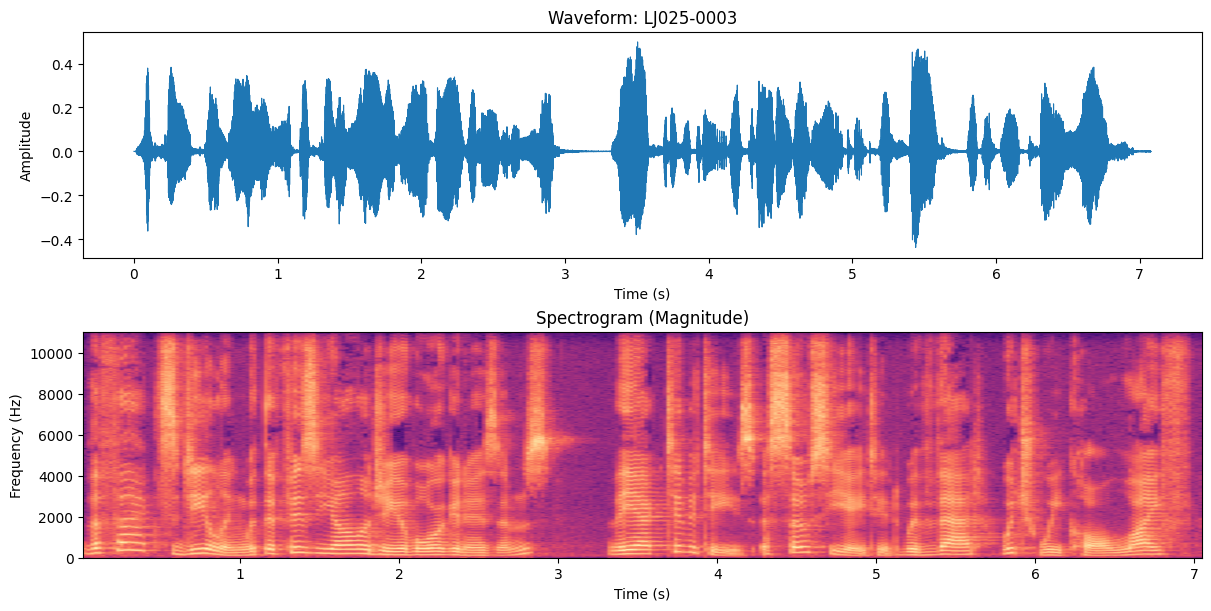

In [7]:
# @title
import os, random
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

# --- pick a random sample from metadata ---
meta = pd.read_csv(globals()["metadata_path"], sep="|", header=None, names=["id","text"], dtype=str)
sample = meta.sample(1).iloc[0]
sample_id = str(sample["id"]).strip()
text = sample.get("norm_text", sample.get("text", ""))
wav_path = os.path.join(globals()["audio_dir"], f"{sample_id}")
if not wav_path.endswith(".wav"):
    wav_path += ".wav"

print(f"🎲 Sample: {sample_id}")
print(f"🗣️  Text: {text}")
print(f"📄 Path: {wav_path}")

# --- load waveform ---
waveform, sr = sf.read(wav_path)
if waveform.ndim > 1:  # stereo → mono
    waveform = np.mean(waveform, axis=1)
duration = len(waveform) / sr
print(f"⏱️  {duration:.2f}s @ {sr} Hz")

# --- plot waveform and spectrogram ---
fig, axs = plt.subplots(2, 1, figsize=(12, 6), constrained_layout=True)

# waveform
axs[0].plot(np.arange(len(waveform)) / sr, waveform, linewidth=0.8)
axs[0].set_title(f"Waveform: {sample_id}")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")

# spectrogram
axs[1].specgram(
    waveform,
    Fs=sr,
    NFFT=1024,
    noverlap=512,
    cmap="magma",
)
axs[1].set_title("Spectrogram (Magnitude)")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Frequency (Hz)")

plt.show()

# --- optional: play audio ---
from IPython.display import Audio
Audio(waveform, rate=sr)


# 🧩 Data Representation: Inputs and Outputs

## Text, Phonemes, and the Mel Spectrogram

Neural text-to-speech systems like **Piper** don’t learn to map *text* directly to *speech waveforms*.  
Instead, they learn an intermediate relationship:

> **Phoneme sequence → Acoustic features (Mel spectrogram)**

This distinction matters because text is highly ambiguous.  
English spelling in particular often encodes pronunciation inconsistently  
(e.g., “though,” “tough,” “through”).  It's also extensive: there are tens of thousands of commonly used english words -- at least hundreds of thousands are documented.

By first converting words into **phonemes** — symbols that represent spoken sounds —  
the model works with a consistent, language-agnostic representation of speech, and a smaller representational space - American English uses 44 distinct phonemes.

##Why phonemes?

Each phoneme corresponds roughly to a distinct mouth position or sound unit.  
For example, the word *“cat”* is represented as `/k æ t/`.  
Using phonemes removes irregularities of spelling and allows the network  
to focus purely on the *acoustic* mapping —  
how each sequence of sounds should look in a Mel spectrogram.

### 🧮 Scale Comparison: English Words vs. Phonemes

| Concept | Approximate Count | Notes |
|----------|------------------:|-------|
| **Distinct English word forms** | ~600,000 – 1,000,000+ | Depending on dictionary and inflections; the Oxford English Dictionary lists ~600k, while large corpora (COCA, Google Books) exceed a million forms when including plurals, tenses, and derived variants. |
| **Commonly used words** | ~20,000 – 30,000 | Represents about 95–98% of typical written or spoken English usage. |
| **English phonemes** | **≈ 40–45** | Varies slightly by dialect; General American English uses around 44 (about 24 consonants and 20 vowels/diphthongs). |
| **Distinct phoneme combinations (triphones)** | ~100,000 – 200,000 | Context-dependent sound units used in older speech recognition and synthesis models. |

---

Mapping *words → audio* would require hundreds of thousands of unique examples,  
making generalization nearly impossible.  

Mapping *phonemes → acoustic frames* reduces the target space dramatically:  
the model only needs to learn how each of a few dozen phonemes sounds  
and how they transition in context.

That’s roughly a **10,000× reduction in input vocabulary size**,  
yet it still captures the full expressive range of spoken English.

---



| Model Type | Input Vocabulary | Characteristics |
|-------------|------------------|----------------|
| **Word-based** | ≈ 1,000,000 items | Extremely sparse and ambiguous |
| **Phoneme-based** | ≈ 40–45 items | Compact, consistent, and directly tied to articulation |

---

### Phonemization process (techical details)

1. **Text normalization** — punctuation, numbers, and abbreviations are expanded  
   (“Dr.” → “Doctor”, “5” → “five”).
2. **Grapheme-to-phoneme conversion** — each word is translated into a sequence of phonemes,  
   often using a pronunciation dictionary or rule-based system (like *eSpeak-NG*).
3. **Prosody and stress marks** — optional cues may be added to model emphasis or rhythm.
4. The resulting phoneme sequence is tokenized and fed into the neural model  
   to predict its acoustic realization in Mel space.

In short, **phonemes are the bridge between linguistic input and acoustic output**.  
Understanding this representation helps explain both the power and the limitations  
of modern neural speech synthesis.

---
## The Mel spectrogram

The Mel spectrogram is a perceptually scaled, time-frequency representation of audio.  
It shows **how the energy of the signal is distributed across frequencies over time**,  
compressed into the “Mel” scale that approximates human pitch perception.

During training, the TTS model learns to predict the sequence of Mel frames
that correspond to each phoneme sequence.  
A separate **vocoder** then reconstructs the audible waveform from those predicted frames.


### 🧠 From Waveform to Spectrogram
A raw audio waveform shows amplitude (loudness) over time — it’s easy for us to plot, but difficult for a neural network to interpret directly.  
To get something more meaningful:
1. The waveform is divided into short overlapping windows (typically 20–50 ms each).  
2. A **Fourier transform** is applied to each window, revealing which frequencies are present and how strong they are.  
3. Stacking these over time forms a **spectrogram**, where the x-axis is time, the y-axis is frequency, and color indicates intensity.

### 🎚️ Why the “Mel” Scale?
Human hearing isn’t linear — we perceive pitch differences more strongly at low frequencies than at high ones.  
The **mel scale** warps the frequency axis so that equal distances correspond to roughly equal perceptual pitch steps.  
This is done by grouping Fourier bins into ~80 “mel bands” using triangular filters spaced according to the mel scale.

### 💬 Why TTS Models Use It
- **Compact representation:** reduces thousands of FFT bins down to a few dozen mel bins, keeping the essential perceptual information.  
- **Perceptual relevance:** aligns better with how humans judge differences in sound quality.  
- **Easier learning:** neural networks can focus on meaningful acoustic patterns (like formants and prosody) instead of raw sample-level noise.  

Most neural TTS models predict a **mel spectrogram** from text, and a separate *vocoder* (such as HiFi-GAN or Piper’s internal model) converts that mel spectrogram back into audible waveform audio.

### 🔍 Summary

| Representation | What it shows | Used for |
|-----------------|---------------|-----------|
| **Waveform** | Amplitude vs. time | Raw audio playback |
| **Spectrogram** | Frequency power vs. time | Generic sound analysis |
| **Mel Spectrogram** | Perceptually scaled frequency power | Model input/output for TTS |


🗣️  Text: The facts dealing with the physiology of organisms, the activities associated with that which we call life

🔤 Phonemes (en-us): D@2 f'akts d'i:lIN wIDD@2 f,IzI2;'0l@dZi; Vv 'O@g@n,Iz@mz
DI2; akt'IvI#t#iz a#s'oUsI2;,eIt#I#d wID Dat_:_: w,ItS wi: k'O:l l'aIf



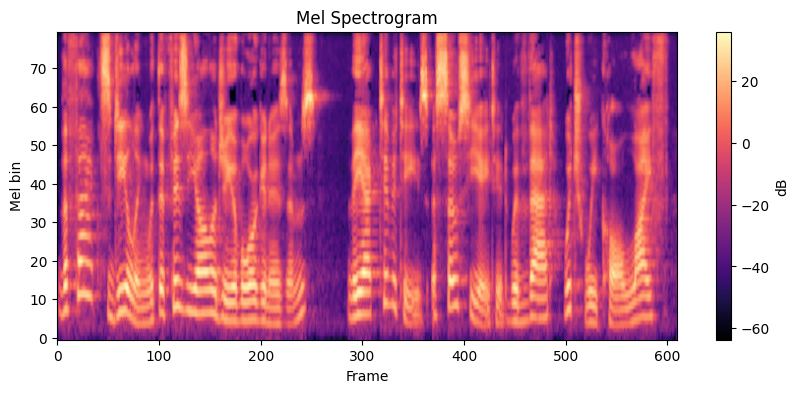

In [8]:
# @title
import torch
import torchaudio
import matplotlib.pyplot as plt
import subprocess

# --- ensure we have text for the current sample ---
if "text" not in globals():
    raise RuntimeError("⚠️ No sample text available — run the sample picker cell first.")

print(f"🗣️  Text: {text}\n")

# --- phoneme extraction using eSpeak-NG ---
try:
    # "-x" → phonemes, "-q" → quiet, "-v" → voice (match dataset's language)
    espeak_voice = "en-us"  # adjust if dataset is in a different language
    result = subprocess.run(
        ["espeak-ng", "-v", espeak_voice, "-q", "-x", text],
        capture_output=True,
        text=True,
        check=True,
    )
    phonemes = result.stdout.strip()
    print(f"🔤 Phonemes ({espeak_voice}): {phonemes}\n")
except Exception as e:
    print(f"⚠️ Could not get phonemes: {e}\n")

# --- convert waveform to tensor for mel-spectrogram ---
wave_tensor = torch.from_numpy(waveform).float().unsqueeze(0)

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=1024,
    hop_length=256,
    n_mels=80,
)
mel = mel_transform(wave_tensor)
mel_db = torchaudio.transforms.AmplitudeToDB()(mel)

# --- plot mel spectrogram ---
plt.figure(figsize=(10, 4))
plt.imshow(mel_db[0].numpy(), origin="lower", aspect="auto", cmap="magma")
plt.colorbar(label="dB")
plt.title("Mel Spectrogram")
plt.xlabel("Frame")
plt.ylabel("Mel bin")
plt.show()


Questions:

+ data representation - calculate data size of raw time data, spectrum, and mel spectrum for one sample.

# Voice Selection
Now that we have our dataset, we need to pick a voice to finetune. A voice in this context is a pretrained neural net model.

## Automation
It might make sense to try an automate picking the "nearest" base voice to start from. This can be formulated as a speaker recognition problem: use some embedding to measure the distance between the dataset speech samples and the available TTS voice models.

The next two cells do this, using the ECAPA speaker recognition encoder to calculate embeddings for all the medium english base voices available, using 10 random utterances from the selected training dataset. It then calculates the cosine similarity for each utterence and each voice, and takes the mean. This may take several minutes to complete.

Since it does not seed the random number generator, you may get different utterances each time you run it, which may change the choice of best base fit. This is not a bug!

The next cell provides an A/B/C comparision of a dataset sample and the best two base voices.

The third cell has you pick a base voice for actual fine tuning. Feel free to go with the automated selection, or pick one of your own.
---

### **Thought question:** Why might the automated "best voice" pick not actually be the best for the retraining task?

First, the automated "best voice" is stochastic, so it's possible to randomly observe a poor "best voice". With different utterances, the embedding distances could produce drastically different estimates. Overall, selecting the best base voice depends on the objective. The analyst must know the content of the speech samples, and which base voice is best equipped to learn the samples. The base voice needs to be trained in the same range of phomenes with an appropriate age/gender/accent of the speech samples.

For example, the two recommended voices generated below are en_US-bryce-medium and en_US-kusal-medium, but, in our opinion, the voices sound nothing like the voice of the samples.

After playing around with the voice samples and listening to several options, we chose en_US-hfc_female-medium. In our opinion, this base voice is more similar to the samples than the automated recommendations. Interestingly, on both automated recommendations, it was near the bottom of the list. This made it an appealing choice, because we are able to see if the model is able to train on a poor base voice (at least in terms of the embedding distances).

In [10]:
# @title
# 🧠 Find the closest English Piper voice to your dataset (multi-text embedding)
from pathlib import Path
import random, torch, torchaudio, numpy as np, soundfile as sf
from speechbrain.pretrained import EncoderClassifier
from huggingface_hub import list_repo_files
from piper import download_voices, PiperVoice
import pandas as pd

# --- Constants ---
CKPT_REPO = "rhasspy/piper-checkpoints"
voices_dir = Path("/content/piper_experiments/voices")
voices_dir.mkdir(parents=True, exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Step 1: Fetch available English "medium" voices ---
print("🔍 Fetching available voices …")
files = list_repo_files(CKPT_REPO, repo_type="dataset")
ckpts = [f for f in files if f.endswith(".ckpt")]

def parse_ckpt_path(path):
    parts = path.split("/")
    if len(parts) >= 5:
        lang_root, lang_id, speaker, quality, _ = parts[-5:]
        return {"lang_root": lang_root, "lang_id": lang_id, "speaker": speaker, "quality": quality}
    return None

entries = [e for e in map(parse_ckpt_path, ckpts) if e]
english = [
    e for e in entries
    if e["lang_root"] == "en"
    and e["lang_id"] == "en_US"
    and e["quality"] == "medium"
    and not (
        "ljs_" in dataset_name
        and "ljspeech" in e["speaker"].lower()
    )
]
voice_ids = sorted({f"{e['lang_id']}-{e['speaker']}-{e['quality']}" for e in english})
print(f"✅ Found {len(voice_ids)} English medium voices.")

# --- Step 2: Ensure ONNX models are available ---
for vid in voice_ids:
    model_path = voices_dir / f"{vid}.onnx"
    if not model_path.exists():
        print(f"📥 Downloading {vid} …")
        download_voices.download_voice(vid, voices_dir)
    else:
        print(f"✅ {vid} already cached.")

# --- Step 3: Speaker embedding model ---
print("🧠 Loading speaker recognizer …")
spk_model = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device": device},
)


# --- Step 4: Pick 10–20 diverse texts from dataset for synthesis ---
meta_path = globals().get("metadata_path")
if meta_path is None:
    raise RuntimeError("No dataset metadata_path found (run dataset selector first).")

df = pd.read_csv(meta_path, sep="|", header=None, dtype=str)
sample_rows = df.dropna().sample(min(10, len(df)))

texts = sample_rows[1].tolist()

wav_paths = [
    Path(globals()["audio_dir"]) / (p if str(p).endswith(".wav") else f"{p}.wav")
    for p in sample_rows[0]
]

print(f"🗣️ Using {len(texts)} matching utterances for both dataset and synthesis.")

# --- Step 5: Embedding helpers ---
def resample_to_16k(audio, sr):
    if sr != 16000:
        audio_t = torch.from_numpy(audio).float()
        resampled = torchaudio.functional.resample(audio_t, sr, 16000)
        return resampled.numpy()
    return audio

def audio_to_emb_batch(audio_list, orig_sr=16000):
    """Resample, pad, and embed a batch of variable-length audio clips."""

    # --- One-pass resample + length tracking ---
    resampled = []
    lengths = []
    max_len = 0
    for a in audio_list:
        a16 = resample_to_16k(a, orig_sr)
        resampled.append(a16)
        L = len(a16)
        lengths.append(L)
        if L > max_len:
            max_len = L

    if max_len == 0:
        raise ValueError("All audio clips are empty!")

    # --- Pre-allocate the batch and fill ---
    batch = np.zeros((len(resampled), max_len), dtype=np.float32)
    for i, a in enumerate(resampled):
        batch[i, :len(a)] = a

    # --- Convert + normalize lengths (fraction of valid samples) ---
    wav_tensor = torch.from_numpy(batch).to(device)
    wav_lens = torch.tensor(lengths, dtype=torch.float32, device=device) / max_len

    # --- Encode with ECAPA ---
    with torch.no_grad():
        embs = spk_model.encode_batch(wav_tensor, wav_lens=wav_lens)

    # --- Drop the singleton axis (N,1,D) → (N,D)
    embs = embs.squeeze(1)

    # --- L2 normalize per embedding ---
    embs = embs.cpu().numpy()
    embs /= np.linalg.norm(embs, axis=1, keepdims=True)
    return embs


def synth_to_embs(voice_id, texts, batch_size=8):
    """Return one embedding per utterance for a given voice."""
    print(f"Embedding utterances for {voice_id}")
    v = PiperVoice.load(voices_dir / f"{voice_id}.onnx")

    # --- Synthesize all utterances ---
    audios = []
    for t in texts:
        chunks = list(v.synthesize(t))
        audio = np.concatenate([c.audio_float_array for c in chunks])
        audios.append(audio)

    # --- Embed in batches ---
    embs = []
    for i in range(0, len(audios), batch_size):
        batch_embs = audio_to_emb_batch(audios[i:i + batch_size], 22050)
        embs.extend(batch_embs)
    return np.array(embs)

# --- Step 6: Compute embeddings for all candidate voices ---
print(f"🎙 Generating embeddings for {len(voice_ids)} candidate voices …")
voice_embs = {vid: synth_to_embs(vid, texts) for vid in voice_ids}

# --- Step 7: Compute embeddings for target dataset utterances ---
print(f"🎧 Embedding {len(wav_paths)} dataset samples …")
dataset_audios = []
for wpath in wav_paths:
    waveform, sr = sf.read(wpath)
    if waveform.ndim > 1:
        waveform = waveform.mean(axis=1)
    dataset_audios.append(waveform)

dataset_embs = audio_to_emb_batch(dataset_audios)

# --- Step 8: Per-utterance cosine similarity ---
scores = {}
for vid, v_embs in voice_embs.items():
    # cosine matrix: (n_dataset, n_synth)
    cosines = dataset_embs @ v_embs.T
    scores[vid] = float(np.mean(cosines))

# Rank results
ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)

print("\n🎯 Closest English base voices (per-utterance comparison):")
for vid, score in ranked:
    print(f"{vid:<25}  {score:.3f}")

best_voice = ranked[0][0]
print(f"\n🏆 Recommended base voice: {best_voice}")
globals()["recommended_base_voice"] = best_voice

🔍 Fetching available voices …


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Found 14 English medium voices.
📥 Downloading en_US-amy-medium …
📥 Downloading en_US-arctic-medium …
📥 Downloading en_US-bryce-medium …
📥 Downloading en_US-hfc_female-medium …
📥 Downloading en_US-hfc_male-medium …
📥 Downloading en_US-joe-medium …
📥 Downloading en_US-john-medium …
📥 Downloading en_US-kristin-medium …
📥 Downloading en_US-kusal-medium …
📥 Downloading en_US-l2arctic-medium …
📥 Downloading en_US-lessac-medium …
📥 Downloading en_US-libritts_r-medium …
📥 Downloading en_US-ryan-medium …
📥 Downloading en_US-sam-medium …


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


🧠 Loading speaker recognizer …


hyperparams.yaml: 0.00B [00:00, ?B/s]

INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
/usr/local/lib/python3.12/dist-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load_if_possible
DEBUG:speechbrain.utils.parameter_transfer:Fetching files for pretraining (no collection directory set)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from Hugg

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/label_encoder.txt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): classifier -> /root/.cache/huggingface/hub/models--speechb

🗣️ Using 10 matching utterances for both dataset and synthesis.
🎙 Generating embeddings for 14 candidate voices …
Embedding utterances for en_US-amy-medium
Embedding utterances for en_US-arctic-medium
Embedding utterances for en_US-bryce-medium
Embedding utterances for en_US-hfc_female-medium
Embedding utterances for en_US-hfc_male-medium
Embedding utterances for en_US-joe-medium
Embedding utterances for en_US-john-medium
Embedding utterances for en_US-kristin-medium
Embedding utterances for en_US-kusal-medium
Embedding utterances for en_US-l2arctic-medium
Embedding utterances for en_US-lessac-medium
Embedding utterances for en_US-libritts_r-medium
Embedding utterances for en_US-ryan-medium
Embedding utterances for en_US-sam-medium
🎧 Embedding 10 dataset samples …

🎯 Closest English base voices (per-utterance comparison):
en_US-bryce-medium         0.149
en_US-ryan-medium          0.143
en_US-kusal-medium         0.138
en_US-arctic-medium        0.103
en_US-l2arctic-medium      0.089
e

In [12]:
# @title
# 🧠 Find the closest English Piper voice to your dataset (multi-text embedding)
from pathlib import Path
import random, torch, torchaudio, numpy as np, soundfile as sf
from speechbrain.pretrained import EncoderClassifier
from huggingface_hub import list_repo_files
from piper import download_voices, PiperVoice
import pandas as pd

# --- Constants ---
CKPT_REPO = "rhasspy/piper-checkpoints"
voices_dir = Path("/content/piper_experiments/voices")
voices_dir.mkdir(parents=True, exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Step 1: Fetch available English "medium" voices ---
print("🔍 Fetching available voices …")
files = list_repo_files(CKPT_REPO, repo_type="dataset")
ckpts = [f for f in files if f.endswith(".ckpt")]

def parse_ckpt_path(path):
    parts = path.split("/")
    if len(parts) >= 5:
        lang_root, lang_id, speaker, quality, _ = parts[-5:]
        return {"lang_root": lang_root, "lang_id": lang_id, "speaker": speaker, "quality": quality}
    return None

entries = [e for e in map(parse_ckpt_path, ckpts) if e]
english = [
    e for e in entries
    if e["lang_root"] == "en"
    and e["lang_id"] == "en_US"
    and e["quality"] == "medium"
    and not (
        "ljs_" in dataset_name
        and "ljspeech" in e["speaker"].lower()
    )
]
voice_ids = sorted({f"{e['lang_id']}-{e['speaker']}-{e['quality']}" for e in english})
print(f"✅ Found {len(voice_ids)} English medium voices.")

# --- Step 2: Ensure ONNX models are available ---
for vid in voice_ids:
    model_path = voices_dir / f"{vid}.onnx"
    if not model_path.exists():
        print(f"📥 Downloading {vid} …")
        download_voices.download_voice(vid, voices_dir)
    else:
        print(f"✅ {vid} already cached.")

# --- Step 3: Speaker embedding model ---
print("🧠 Loading speaker recognizer …")
# Update torchaudio to a compatible version
!pip install --upgrade torchaudio>=2.1
spk_model = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device": device},
)


# --- Step 4: Pick 10–20 diverse texts from dataset for synthesis ---
meta_path = globals().get("metadata_path")
if meta_path is None:
    raise RuntimeError("No dataset metadata_path found (run dataset selector first).")

df = pd.read_csv(meta_path, sep="|", header=None, dtype=str)
sample_rows = df.dropna().sample(min(10, len(df)))

texts = sample_rows[1].tolist()

wav_paths = [
    Path(globals()["audio_dir"]) / (p if str(p).endswith(".wav") else f"{p}.wav")
    for p in sample_rows[0]
]

print(f"🗣️ Using {len(texts)} matching utterances for both dataset and synthesis.")

# --- Step 5: Embedding helpers ---
def resample_to_16k(audio, sr):
    if sr != 16000:
        audio_t = torch.from_numpy(audio).float()
        resampled = torchaudio.functional.resample(audio_t, sr, 16000)
        return resampled.numpy()
    return audio

def audio_to_emb_batch(audio_list, orig_sr=16000):
    """Resample, pad, and embed a batch of variable-length audio clips."""

    # --- One-pass resample + length tracking ---
    resampled = []
    lengths = []
    max_len = 0
    for a in audio_list:
        a16 = resample_to_16k(a, orig_sr)
        resampled.append(a16)
        L = len(a16)
        lengths.append(L)
        if L > max_len:
            max_len = L

    if max_len == 0:
        raise ValueError("All audio clips are empty!")

    # --- Pre-allocate the batch and fill ---
    batch = np.zeros((len(resampled), max_len), dtype=np.float32)
    for i, a in enumerate(resampled):
        batch[i, :len(a)] = a

    # --- Convert + normalize lengths (fraction of valid samples) ---
    wav_tensor = torch.from_numpy(batch).to(device)
    wav_lens = torch.tensor(lengths, dtype=torch.float32, device=device) / max_len

    # --- Encode with ECAPA ---
    with torch.no_grad():
        embs = spk_model.encode_batch(wav_tensor, wav_lens=wav_lens)

    # --- Drop the singleton axis (N,1,D) → (N,D)
    embs = embs.squeeze(1)

    # --- L2 normalize per embedding ---
    embs = embs.cpu().numpy()
    embs /= np.linalg.norm(embs, axis=1, keepdims=True)
    return embs


def synth_to_embs(voice_id, texts, batch_size=8):
    """Return one embedding per utterance for a given voice."""
    print(f"Embedding utterances for {voice_id}")
    v = PiperVoice.load(voices_dir / f"{voice_id}.onnx")

    # --- Synthesize all utterances ---
    audios = []
    for t in texts:
        chunks = list(v.synthesize(t))
        audio = np.concatenate([c.audio_float_array for c in chunks])
        audios.append(audio)

    # --- Embed in batches ---
    embs = []
    for i in range(0, len(audios), batch_size):
        batch_embs = audio_to_emb_batch(audios[i:i + batch_size], 22050)
        embs.extend(batch_embs)
    return np.array(embs)

# --- Step 6: Compute embeddings for all candidate voices ---
print(f"🎙 Generating embeddings for {len(voice_ids)} candidate voices …")
voice_embs = {vid: synth_to_embs(vid, texts) for vid in voice_ids}

# --- Step 7: Compute embeddings for target dataset utterances ---
print(f"🎧 Embedding {len(wav_paths)} dataset samples …")
dataset_audios = []
for wpath in wav_paths:
    waveform, sr = sf.read(wpath)
    if waveform.ndim > 1:
        waveform = waveform.mean(axis=1)
    dataset_audios.append(waveform)

dataset_embs = audio_to_emb_batch(dataset_audios)

# --- Step 8: Per-utterance cosine similarity ---
scores = {}
for vid, v_embs in voice_embs.items():
    # cosine matrix: (n_dataset, n_synth)
    cosines = dataset_embs @ v_embs.T
    scores[vid] = float(np.mean(cosines))

# Rank results
ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)

print("\n🎯 Closest English base voices (per-utterance comparison):")
for vid, score in ranked:
    print(f"{vid:<25}  {score:.3f}")

best_voice = ranked[0][0]
print(f"\n🏆 Recommended base voice: {best_voice}")
globals()["recommended_base_voice"] = best_voice

🔍 Fetching available voices …
✅ Found 14 English medium voices.
✅ en_US-amy-medium already cached.
✅ en_US-arctic-medium already cached.
✅ en_US-bryce-medium already cached.
✅ en_US-hfc_female-medium already cached.
✅ en_US-hfc_male-medium already cached.
✅ en_US-joe-medium already cached.
✅ en_US-john-medium already cached.
✅ en_US-kristin-medium already cached.
✅ en_US-kusal-medium already cached.
✅ en_US-l2arctic-medium already cached.
✅ en_US-lessac-medium already cached.
✅ en_US-libritts_r-medium already cached.
✅ en_US-ryan-medium already cached.
✅ en_US-sam-medium already cached.
🧠 Loading speaker recognizer …


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Fetching files for pretraining (no collection directory set)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/hugg

🗣️ Using 10 matching utterances for both dataset and synthesis.
🎙 Generating embeddings for 14 candidate voices …
Embedding utterances for en_US-amy-medium
Embedding utterances for en_US-arctic-medium
Embedding utterances for en_US-bryce-medium
Embedding utterances for en_US-hfc_female-medium
Embedding utterances for en_US-hfc_male-medium
Embedding utterances for en_US-joe-medium
Embedding utterances for en_US-john-medium
Embedding utterances for en_US-kristin-medium
Embedding utterances for en_US-kusal-medium
Embedding utterances for en_US-l2arctic-medium
Embedding utterances for en_US-lessac-medium
Embedding utterances for en_US-libritts_r-medium
Embedding utterances for en_US-ryan-medium
Embedding utterances for en_US-sam-medium
🎧 Embedding 10 dataset samples …

🎯 Closest English base voices (per-utterance comparison):
en_US-kusal-medium         0.167
en_US-bryce-medium         0.135
en_US-arctic-medium        0.121
en_US-ryan-medium          0.095
en_US-kristin-medium       0.082
e

In [13]:
# @title
# 🎧 A/B/C listen: random dataset sample vs. recommended base voices
import random, numpy as np, soundfile as sf, pandas as pd
from IPython.display import Audio, display, HTML
from pathlib import Path
from piper.voice import PiperVoice

# --- prerequisites from your notebook ---
meta_path = globals().get("metadata_path")
audio_dir = globals().get("audio_dir")
recommended = globals().get("recommended_base_voice")
second_rec = ranked[1][0]
voices_dir = Path("/content/piper_experiments/voices")

if not (meta_path and audio_dir and recommended):
    raise RuntimeError("Missing one of: metadata_path, audio_dir, recommended_base_voice")

# --- load metadata and pick a random row ---
df = pd.read_csv(meta_path, sep="|", header=None, dtype=str)
df.columns = ["id", "text", *df.columns[2:]]  # tolerate extra columns
row = df.sample(1).iloc[0]
utt_id = str(row["id"]).strip()
text = str(row["text"]).strip()

# --- resolve audio path ---
wav_path = os.path.join(audio_dir, utt_id)
if not wav_path.endswith(".wav"):
    wav_path += ".wav"
wav_path = Path(wav_path)
if not wav_path.exists():
    raise FileNotFoundError(f"Could not find {wav_path}")

# --- load dataset recording ---
y, sr = sf.read(wav_path)
if y.ndim > 1:
    y = y.mean(axis=1)

# --- synthesize same text with recommended voice ---
voice = PiperVoice.load(voices_dir / f"{recommended}.onnx")
chunks = list(voice.synthesize(text))
y_syn = np.concatenate([c.audio_float_array for c in chunks])
sr_syn = chunks[0].sample_rate if chunks else 22050

# --- and second recommended voice ---
voice = PiperVoice.load(voices_dir / f"{second_rec}.onnx")
chunks = list(voice.synthesize(text))
y_syn_2 = np.concatenate([c.audio_float_array for c in chunks])
sr_syn_2 = chunks[0].sample_rate if chunks else 22050

# --- display side-by-side audio boxes ---
display(HTML(f"""
<h4>🎯 A/B Comparison</h4>
<p><b>Text:</b> {text}</p>
<div style="display:flex; gap:24px; flex-wrap:wrap; align-items:flex-start">
  <div>
    <div><b>Dataset recording</b><br><small>{wav_path.name}</small></div>
    {Audio(y, rate=sr)._repr_html_()}
  </div>
  <div>
    <div><b>Recommended voice</b><br><small>{recommended}</small></div>
    {Audio(y_syn, rate=sr_syn)._repr_html_()}
  </div>
  <div>
    <div><b>Second recommended voice</b><br><small>{second_rec}</small></div>
    {Audio(y_syn_2, rate=sr_syn_2)._repr_html_()}
  </div>
</div>
"""))


# Voice (Model) Selection
Use the selector below to try the various medium quality English voices to start from. Common sense say it may be best to select a voice that sounds as much like the voice you wish to train to, but it might be interesting to see how faraway you can be and still train a good voice. Alternatively, how much can training be reduced (in data or time) by starting from a good match.

In [14]:
# @title
# --- Piper Voice Selector (no ckpt download, just build HF URL) ---

import ipywidgets as widgets
from IPython.display import display, Audio, Markdown
from piper import download_voices, PiperVoice
from huggingface_hub import list_repo_files
import requests
from pathlib import Path

# 📁 Hugging Face dataset with checkpoints
CKPT_REPO = "rhasspy/piper-checkpoints"

# 🔍 Fetch list of checkpoint files
files = list_repo_files(CKPT_REPO, repo_type="dataset")
ckpts = [f for f in files if f.endswith(".ckpt")]

# 🧩 Parse into components: lang_root, lang_id, speaker, quality
def parse_ckpt_path(path):
    parts = path.split("/")
    if len(parts) >= 5:
        lang_root, lang_id, speaker, quality, fname = parts[-5:]
        return {
            "lang_root": lang_root,
            "lang_id": lang_id,
            "speaker": speaker,
            "quality": quality,
            "ckpt_path": path,
        }
    return None

entries = [e for e in map(parse_ckpt_path, ckpts) if e]
# 🇬🇧 Filter to English, medium quality, non-LJS voices, if fitting ljspeech
english = [
    e for e in entries
    if e["lang_root"] == "en"
    and e["quality"] == "medium"
    and not (
        "ljs_" in dataset_name
        and "ljspeech" in e["speaker"].lower()
    )
]

# 🎙 Build dropdown
options = [
    (f"{e['speaker']} ({e['lang_id']}-{e['quality']})", e["ckpt_path"])
    for e in english
]
voice_dd = widgets.Dropdown(
    options=options,
    description="🎙 Voice:",
    value= None,
)

# 🎧 Buttons + output area
preview_btn = widgets.Button(description="🎧 Select this Voice", button_style="info")
out = widgets.Output()

# 📁 Voice download path
voices_dir = Path("/content/piper_experiments/voices")
voices_dir.mkdir(parents=True, exist_ok=True)

# 🔧 Universal ONNX voice loader (for previews and baseline samples)

VOICES_REPO = "rhasspy/piper-checkpoints"      # or your CKPT_REPO variable
VOICES_DIR = Path("/content/piper_experiments/voices")
VOICES_DIR.mkdir(parents=True, exist_ok=True)

def load_voice_model(ckpt_path_or_voiceid: str):
    """
    Ensure a Piper ONNX voice (and its JSON config) are available locally,
    then load it as a PiperVoice instance.

    Accepts either:
      - a voice_id like 'en_GB-alan-medium', OR
      - a full HF-style subpath like 'en/en_GB/alan/medium/epoch=6339-step=1647790.ckpt'
    """
    # normalize to voice_id
    if ckpt_path_or_voiceid.endswith(".ckpt"):
        parts = ckpt_path_or_voiceid.split("/")
        lang_id, speaker, quality = parts[-4:-1]
        voice_id = f"{lang_id}-{speaker}-{quality}"
    else:
        voice_id = ckpt_path_or_voiceid

    # download if missing
    model_path = VOICES_DIR / f"{voice_id}.onnx"
    config_path = VOICES_DIR / f"{voice_id}.onnx.json"
    if not model_path.exists() or not config_path.exists():
        print(f"📥 Downloading ONNX voice '{voice_id}' …")
        download_voices.download_voice(voice_id, VOICES_DIR)

    # load model
    voice = PiperVoice.load(model_path)
    return voice_id, voice

# 🎵 Play sample using .onnx model (auto-downloaded)
def on_preview(_):
    out.clear_output(wait=True)
    with out:
        ckpt_path = voice_dd.value
        voice_id, voice = load_voice_model(ckpt_path)
        print(f"🎤 Selected voice: {voice_id}")

        phrase = "Hello! This is a sample of your chosen voice."
        print(f"🎙 Synthesizing: {phrase}")
        audio_chunks = list(voice.synthesize(phrase))
        import numpy as np
        from IPython.display import Audio, display
        audio = np.concatenate([c.audio_float_array for c in audio_chunks])
        display(Audio(data=audio, rate=audio_chunks[0].sample_rate))
        globals()["selected_ckpt_url"] = f"https://huggingface.co/datasets/{VOICES_REPO}/resolve/main/{ckpt_path}"
        globals()["selected_voice_id"] = voice_id

preview_btn.on_click(on_preview)

if "recommended_base_voice" in globals():
    lang,spk,qual = recommended_base_voice.split("-")
    rec = f"{spk} ({lang}-{qual})"
    voice_dd.value = [value for (label, value) in voice_dd.options if rec == label][0]

ui = widgets.VBox([
    widgets.HTML("<h3>🎚 Select a base voice to fine-tune</h3>"),
    widgets.HBox([voice_dd, preview_btn]),
    out])
display(ui)


# A Voice is a Pretrained Model

In order to modify an existng model for a new speaker, it is best if we understand the structure of the model, so that potentially can save training time by not retraining speaker independent parts of the model. We're also going to need exact names for the various parts of the model that have so far been represnted as boxes in diagrams.

Now that we've selected a model, let's load it and see what we an tell about it, programtically.

In [15]:
# @title
# Load the model
from piper.train.vits.lightning import VitsModel
model = VitsModel.load_from_checkpoint(selected_ckpt_url)


Downloading: "https://huggingface.co/datasets/rhasspy/piper-checkpoints/resolve/main/en/en_US/hfc_female/medium/epoch=2868-step=1575188.ckpt" to /root/.cache/torch/hub/checkpoints/epoch=2868-step=1575188.ckpt


100%|██████████| 807M/807M [00:18<00:00, 45.2MB/s]
INFO: Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.6.0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint https:/huggingface.co/datasets/rhasspy/piper-checkpoints/resolve/main/en/en_US/hfc_female/medium/epoch=2868-step=1575188.ckpt`
INFO:lightning.pytorch.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.6.0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint https:/huggingface.co/datasets/rhasspy/piper-checkpoints/resolve/main/en/en_US/hfc_female/medium/epoch=2868-step=1575188.ckpt`
/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [16]:
# Torch models have a somewhat readable text representation
model.eval()
model.train(True)

VitsModel(
  (model_g): SynthesizerTrn(
    (enc_p): TextEncoder(
      (emb): Embedding(256, 192)
      (encoder): Encoder(
        (drop): Dropout(p=0.1, inplace=False)
        (attn_layers): ModuleList(
          (0-5): 6 x MultiHeadAttention(
            (conv_q): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
            (conv_k): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
            (conv_v): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
            (conv_o): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
            (drop): Dropout(p=0.1, inplace=False)
          )
        )
        (norm_layers_1): ModuleList(
          (0-5): 6 x LayerNorm()
        )
        (ffn_layers): ModuleList(
          (0-5): 6 x FFN(
            (conv_1): Conv1d(192, 768, kernel_size=(3,), stride=(1,))
            (conv_2): Conv1d(768, 192, kernel_size=(3,), stride=(1,))
            (drop): Dropout(p=0.1, inplace=False)
          )
        )
        (norm_layers_2): ModuleList(
          (0

# Reading the model
There's a lot in that tree structure that looks familiar: Seems to be a fairly standard Torch NN model. Carefully examining the indentation shows two toplevel items: model_g and model_d. The first is a SynthesizerTrn - the Transformer generator. The second, model_d, is a MultiPeriod Discriminator

 The text encoder, for example, is the first then described,. We see a 6-fold multi-head self-attention layer. It is a bit hard to correlate it with the block diagram from the paper. Let's explore a bit.

In [17]:
print(model.__class__.__name__)
for name, module in model.named_children():
    print(f"{name:<15} {module.__class__.__name__}")


VitsModel
model_g         SynthesizerTrn
model_d         MultiPeriodDiscriminator


Ok, we've got two top level modules, the Generator module and the Discriminator module. We'll need to focus on the first:

In [18]:
for name, module in model.model_g.named_children():
    print(f"{name:<15} {module.__class__.__name__}")


enc_p           TextEncoder
dec             Generator
enc_q           PosteriorEncoder
flow            ResidualCouplingBlock
dp              StochasticDurationPredictor


So, here we have the expected components of the generator. For retraining a model for a new speaker, we can freeze the Text Encoder, and the Flow, since thses parts are speaker independent, as long as we're staing in the same langauge and phoneme set.


| Module | Retrain for new speaker |
|:-------|:-------------------------|
| `enc_p` (Text Encoder) | ❌ Freeze |
| `enc_q` (Posterior Encoder) | ✅ Train |
| `flow` (Normalizing Flow) | ❌ Freeze |
| `dec` (Decoder) | ✅ Train |
| `dp` (Duration Predictor) | ✅ Train |


In [19]:
import torch
import pandas as pd

def summarize_vits_model(model):
    def count_params(m):
        return sum(p.numel() for p in m.parameters())
    def count_trainable(m):
        return sum(p.numel() for p in m.parameters() if p.requires_grad)

    parts = {
        "Text Encoder (enc_p)": model.model_g.enc_p,
        "Posterior Encoder (enc_q)": model.model_g.enc_q,
        "Flow (flow)": model.model_g.flow,
        "Decoder (dec)": model.model_g.dec,
        "Duration Predictor (dp)": model.model_g.dp,
    }

    rows = []
    for name, module in parts.items():
        params = count_params(module)
        trainable = count_trainable(module)
        pct = 100 * trainable / params if params > 0 else 0

        # Representative tensor shape where meaningful
        if hasattr(module, "emb"):  # text encoder embedding
            shape = tuple(module.emb.weight.shape)
        elif hasattr(module, "conv_pre"):  # decoder input
            shape = (module.conv_pre.in_channels, module.conv_pre.out_channels)
        elif hasattr(module, "pre"):  # posterior encoder or flow
            shape = tuple(module.pre.weight.shape) if hasattr(module.pre, "weight") else "—"
        else:
            shape = "—"

        rows.append({
            "Module": name,
            "Parameters": f"{params/1e6:.2f} M",
            "Trainable": f"{pct:.1f}%",
            "Key Shape": shape,
        })

    df = pd.DataFrame(rows)
    total = count_params(model)
    trainable = count_trainable(model)
    summary = f"Total parameters: {total/1e6:.2f} M  |  Trainable: {trainable/1e6:.2f} M  ({100*trainable/total:.1f}%)"

    display(df)
    print(summary)

summarize_vits_model(model)



,Module,Parameters,Trainable,Key Shape
0,Text Encoder (enc_p),6.34 M,100.0%,"(256, 192)"
1,Posterior Encoder (enc_q),7.24 M,100.0%,"(192, 513, 1)"
2,Flow (flow),7.10 M,100.0%,—
3,Decoder (dec),1.66 M,100.0%,"(192, 256)"
4,Duration Predictor (dp),1.32 M,100.0%,"(192, 192, 1)"


Total parameters: 70.41 M  |  Trainable: 70.41 M  (100.0%)


# Speaker Retraining / Fine Tuning
Finally, ready to go. This is the part of the notebook that will take significant GPU cycles. 100 epochs with 1000 samples will take about two hours, consuming 3-4 compute units on an L4 instance. On an A100, with appropriate batch size, this takes 15 minutes. Training is resumable: the same dataset and voice will continue from an existing fit, so feel free to try some short runs to get the feel for how training is progressing.

Outputs will be in the "runs" folder under the project root (piper_experiments).
Additional runs with the same parameters (same dataset, base voice, and freeze state) will resume the existing training, and create a new version folder.

In [20]:
# @title
# 🎙 Piper fine-tuning run (in-process, freeze-aware, correct imports & resume)
import os, re, json, sys, torch
from pathlib import Path
from urllib.parse import urlparse, unquote
from datetime import datetime

# =============================================================================
# SETTINGS
additional_epochs = 200
batch_size = 160          # e.g. 20 for T4; 32 for L4; 160+ for A100
espeak_voice = "en-us"
freeze = True    # 🔒 freeze enc_p + flow when True
# =============================================================================

# --- Required globals ---
if "metadata_path" not in globals() or "audio_dir" not in globals():
    raise RuntimeError("❌ metadata_path/audio_dir not set. Run the dataset selector first.")
if "selected_ckpt_url" not in globals():
    raise RuntimeError("❌ selected_ckpt_url not set. Run the base voice selector first.")

# --- Helpers -----------------------------------------------------------------
def checkpoint_tag(ckpt_url_or_path: str) -> str:
    """Extract a stable 'lang-spk-size' tag from HF-style paths or filenames."""
    s = str(ckpt_url_or_path)
    p = urlparse(s)
    path = unquote(p.path) if p.scheme else s
    parts = Path(path).parts
    lang_re = re.compile(r"^[a-z]{2,3}_[A-Z]{2,3}$")
    for i, part in enumerate(parts):
        if lang_re.match(part) and i + 2 < len(parts):
            lang, speaker, size = parts[i : i + 3]
            return f"{lang}-{speaker}-{size}"
    name = Path(path).stem
    name = re.sub(r"(epoch=.*|step=.*)", "", name)
    return re.sub(r"[^A-Za-z0-9_]+", "_", name).strip("_") or "voice"

def get_epoch_num(p) -> int:
    s = str(p)
    m = re.search(r"epoch=(\d+)", s)
    if m:
        return int(m.group(1))
    try:
        return int(Path(s).stem.split("-")[-1])
    except Exception:
        return 0

# --- Derive tags & run root (dataset + subset + voice + freeze) --------------
meta_name = Path(metadata_path).stem
subset_label = "full" if meta_name == "metadata" else re.sub(r"^metadata_subset_", "", meta_name)
dataset_name = Path(metadata_path).parent.name
base_tag = checkpoint_tag(selected_ckpt_url)
run_suffix = "_freeze" if freeze else ""
voice_name = f"{dataset_name}_{subset_label}_{base_tag}"
run_name = f"{voice_name}{run_suffix}"
run_root = Path(f"/content/piper_experiments/runs/{run_name}")
run_root.mkdir(parents=True, exist_ok=True)
config_out = run_root / f"{voice_name}.json"

# --- Resume detection (only within this run_root) ----------------------------
search_root = run_root / "lightning_logs"
ckpts = list(search_root.glob("**/checkpoints/*.ckpt"))
if ckpts:
    ckpts.sort(key=lambda p: (get_epoch_num(p), os.path.getmtime(p)))
    resume_ckpt = str(ckpts[-1])
    start_epoch = get_epoch_num(ckpts[-1])
    print(f"🔁 Resuming from checkpoint: {resume_ckpt} (epoch {start_epoch})")
else:
    # New run
    # --- generate BEFORE samples using the base ONNX model ---
    def generate_samples(voice, out_dir: Path, samples, label="samples"):
        """Generate one WAV per text sample using a loaded PiperVoice."""
        out_dir.mkdir(parents=True, exist_ok=True)
        for i, text in enumerate(samples, 1):
            stub = re.sub(r"[^a-z0-9]+", "_", text.lower().strip())[:30].strip("_")
            wav_path = out_dir / f"{i:02d}_{stub}.wav"
            if wav_path.exists():
                continue
            chunks = list(voice.synthesize(text))
            audio = np.concatenate([c.audio_float_array for c in chunks])
            sf.write(str(wav_path), audio, chunks[0].sample_rate)
        print(f"✅ {label}: wrote {len(list(out_dir.glob('*.wav')))} files → {out_dir}")

    before_dir = run_root / "before"
    if not before_dir.exists() or not any(before_dir.glob("*.wav")):
        voice_id, voice = load_voice_model(selected_voice_id)
        before_dir.mkdir(parents=True, exist_ok=True)
        print(f"🎙 Generating BEFORE samples for base voice {selected_voice_id}")

        test_sentences = [
            "Hello there! This is the base voice before fine tuning.",
            "The quick brown fox jumps over the lazy dog.",
            "Deep learning lets computers talk with surprisingly natural voices.",
        ]
        generate_samples(voice, before_dir, test_sentences, label="BEFORE samples")

    resume_ckpt = None
    start_epoch = get_epoch_num(selected_ckpt_url)
    print(f"🌱 New fine-tune from base: {base_tag} (start epoch {start_epoch})")

start_ckpt = resume_ckpt or selected_ckpt_url
# --- Epoch schedule -----------------------------------------------------------
max_epochs = start_epoch + additional_epochs + 1
print(f"→ Max total epochs this run: {max_epochs}")

# Clean sys.argv to avoid Jupyter flags
sys.argv = [sys.argv[0]]

# --- Build CLI args (like `python -m piper.train fit ...`) -------------------
args = [
    "--data.voice_name", voice_name,
    "--data.csv_path", str(metadata_path),
    "--data.audio_dir", str(audio_dir),
    "--data.cache_dir", "/content/piper_experiments/cache",
    "--data.espeak_voice", espeak_voice,
    "--data.batch_size", str(batch_size),
    "--data.config_path", str(config_out),
    "--model.sample_rate", "22050",      # linked to data.sample_rate via CLI
    "--trainer.default_root_dir", str(run_root),
    "--trainer.max_epochs", str(max_epochs),
    "--trainer.enable_progress_bar", "true",
    "--trainer.logger", "True",
]

# --- Imports (your tree exports CLI/model/datamodule from piper.train.vits) ---
from piper.train.__main__ import VitsLightningCLI  # wrapped CLI
from piper.train.vits.lightning import VitsModel        # model class
from piper.train.vits.dataset import VitsDataModule     # datamodule class

# --- Init CLI (builds model/datamodule/trainer but does not start fit) -------
import logging
logging.basicConfig(level=logging.INFO)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.deterministic = False

cli = VitsLightningCLI(
    VitsModel,
    VitsDataModule,
    run=False,
    trainer_defaults={"max_epochs": -1},  # actual max comes from args above
    args=args,
)
datamodule = cli.datamodule
trainer = cli.trainer

model = VitsModel.load_from_checkpoint(start_ckpt)


# --- Freeze policy BEFORE fit (so optimizer excludes frozen params) -----------
if freeze:
    print("🧊 Freezing enc_p (text encoder) and flow")
    for p in model.model_g.enc_p.parameters():
        p.requires_grad = False
    for p in model.model_g.flow.parameters():
        p.requires_grad = False

# --- Sanity print ------------------------------------------------------------
print(f"\n🎧 Training configuration:")
print(f" - Dataset: {metadata_path}")
print(f" - Audio dir: {audio_dir}")
print(f" - Base voice: {base_tag}")
print(f" - Starting checkpoint: {start_ckpt}")
print(f" - Additional epochs: {additional_epochs}")
print(f" - Max total epochs: {max_epochs}")
print(f" - Run folder: {run_root}")
print(f" - Config output: {config_out}\n")

# --- Parameter counts --------------------------------------------------------
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
total = trainable + frozen
trainable_pct = 100 * trainable / total if total else 0

print(f"Params: trainable={trainable/1e6:.2f}M / total={total/1e6:.2f}M ({trainable_pct:.1f}% trainable)")

# --- Determine the version number for this upcoming run ----------------------
ll_root = run_root / "lightning_logs"
ll_root.mkdir(parents=True, exist_ok=True)

existing = sorted(ll_root.glob("version_*"))
next_version = len(existing)   # Lightning will assign this

run_info = {
    "version": next_version,
    "dataset": str(metadata_path),
    "audio_dir": str(audio_dir),
    "base_voice": base_tag,
    "start_ckpt": str(start_ckpt),
    "start_epoch": start_epoch,
    "additional_epochs": additional_epochs,
    "max_epochs": max_epochs,
    "run_folder": str(run_root),
    "freeze": freeze,
    "timestamp": datetime.now().isoformat(timespec="seconds"),

    # NEW: parameter metrics
    "params_total": total,
    "params_trainable": trainable,
    "params_frozen": frozen,
    "trainable_percent": trainable_pct,
}

run_info_path = run_root / f"run_info_{next_version}.json"
with open(run_info_path, "w") as f:
    json.dump(run_info, f, indent=2)
print(f"📝 Wrote run metadata → {run_info_path}")


# --- Launch training in-process ----------------------------------------------
print("🚀 Launching fine-tune…")
trainer.fit(model, datamodule, ckpt_path=start_ckpt)
print("✅ Fine-tune complete.")
save_run_to_drive(run_root.name, run_root.parent, drive_root / "runs")

🎙 Generating BEFORE samples for base voice en_US-hfc_female-medium
✅ BEFORE samples: wrote 3 files → /content/piper_experiments/runs/ljs_short_dataset_full_en_US-hfc_female-medium_freeze/before
🌱 New fine-tune from base: en_US-hfc_female-medium (start epoch 2868)
→ Max total epochs this run: 3069


/usr/local/lib/python3.12/dist-packages/lightning/fabric/utilities/seed.py:44: No seed found, seed set to 0
INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:

🧊 Freezing enc_p (text encoder) and flow

🎧 Training configuration:
 - Dataset: /content/piper_experiments/datasets/ljs_short_dataset/metadata.csv
 - Audio dir: /content/piper_experiments/datasets/ljs_short_dataset/wavs
 - Base voice: en_US-hfc_female-medium
 - Starting checkpoint: https://huggingface.co/datasets/rhasspy/piper-checkpoints/resolve/main/en/en_US/hfc_female/medium/epoch=2868-step=1575188.ckpt
 - Additional epochs: 200
 - Max total epochs: 3069
 - Run folder: /content/piper_experiments/runs/ljs_short_dataset_full_en_US-hfc_female-medium_freeze
 - Config output: /content/piper_experiments/runs/ljs_short_dataset_full_en_US-hfc_female-medium_freeze/ljs_short_dataset_full_en_US-hfc_female-medium.json

Params: trainable=56.97M / total=70.41M (80.9% trainable)
📝 Wrote run metadata → /content/piper_experiments/runs/ljs_short_dataset_full_en_US-hfc_female-medium_freeze/run_info_0.json
🚀 Launching fine-tune…


INFO: Restoring states from the checkpoint path at https://huggingface.co/datasets/rhasspy/piper-checkpoints/resolve/main/en/en_US/hfc_female/medium/epoch=2868-step=1575188.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at https://huggingface.co/datasets/rhasspy/piper-checkpoints/resolve/main/en/en_US/hfc_female/medium/epoch=2868-step=1575188.ckpt
INFO: Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.6.0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint https:/huggingface.co/datasets/rhasspy/piper-checkpoints/resolve/main/en/en_US/hfc_female/medium/epoch=2868-step=1575188.ckpt`
INFO:lightning.pytorch.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.6.0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint https:/huggingface.co/datasets/rhasspy/piper-ch

┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model_g │ SynthesizerTrn           │ 23.7 M │ train │     0 │
│ 1 │ model_d │ MultiPeriodDiscriminator │ 46.7 M │ train │     0 │
└───┴─────────┴──────────────────────────┴────────┴───────┴───────┘

Trainable params: 57.0 M                                                                                           
Non-trainable params: 13.4 M                                                                                       
Total params: 70.4 M                                                                                               
Total estimated model params size (MB): 281                                                                        
Modules in train mode: 504                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

INFO: Restored all states from the checkpoint at https://huggingface.co/datasets/rhasspy/piper-checkpoints/resolve/main/en/en_US/hfc_female/medium/epoch=2868-step=1575188.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at https://huggingface.co/datasets/rhasspy/piper-checkpoints/resolve/main/en/en_US/hfc_female/medium/epoch=2868-step=1575188.ckpt


Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:317: The number of training batches (6)
is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you 
want to see logs for the training epoch.

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
RuntimeError: CUDA out of memory. Tried to allocate 94.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 436241 has 14.73 GiB memory in use. Of the allocated memory 12.24 GiB is allocated by PyTorch, and 2.36 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)



In [ ]:
!pkill -f tensorboard
%load_ext tensorboard
%tensorboard --logdir {run_root} --port 6006

# Export the new voice model
THe following cell will find all runs that do not have an exported voice model, and export the most recent model for that version run. Execute it after a fit.

In [ ]:
# @title

# 🧭 Export all missing fine-tuned Piper checkpoints (per version) to ONNX
import os, re, subprocess, shutil
from pathlib import Path

base_runs = Path("/content/piper_experiments/runs")
if not base_runs.exists():
    raise RuntimeError("❌ No runs directory found.")

def get_epoch_num(path: Path):
    m = re.search(r"epoch=(\d+)", path.name)
    return int(m.group(1)) if m else -1

for run_root in sorted(base_runs.glob("*")):
    log_root = run_root / "lightning_logs"
    if not log_root.exists():
        continue

    # --- Identify the **correct** Piper model config JSON ---
    #   Pattern:   {voice_name}.json
    #   Where voice_name is the run folder name *minus* optional _freeze
    run_name = run_root.name
    voice_json_prefix = run_name.replace("_freeze", "")

    config_src = run_root / f"{voice_json_prefix}.json"

    if not config_src.exists():
        print(f"⚠️ {run_root.name}: expected config {config_src.name} not found.")
        # fallback: try first .json that is NOT a run_info or .unzipped marker
        for jf in run_root.glob("*.json"):
            if "run_info" not in jf.name and "unzipped" not in jf.name:
                config_src = jf
                break
        else:
            print(f"❌ No valid config JSON found for {run_root.name}, skipping.")
            continue

    # each version_* has its own checkpoints folder
    versions = sorted(log_root.glob("version_*"))
    if not versions:
        print(f"⚠️ {run_root.name}: no version folders found.")
        continue

    for version_dir in versions:
        ckpts = list(version_dir.glob("checkpoints/*.ckpt"))
        if not ckpts:
            print(f"ℹ️ {run_root.name}/{version_dir.name}: no checkpoints.")
            continue

        ckpts.sort(key=lambda p: (get_epoch_num(p), os.path.getmtime(p)))
        best_ckpt = ckpts[-1]

        # Compose ONNX output names with version suffix
        run_name = run_root.name
        version_id = re.search(r"version_(\d+)", version_dir.name)
        version_suffix = f"_v{version_id.group(1)}" if version_id else ""
        onnx_out = version_dir / f"{run_name}{version_suffix}.onnx"
        onnx_json = onnx_out.with_suffix(onnx_out.suffix + ".json")

        if onnx_out.exists() and onnx_json.exists():
            print(f"✅ {run_name}/{version_dir.name}: ONNX already present ({onnx_out.name}), skipping.")
            continue

        print(f"\n🎯 {run_name}/{version_dir.name}: exporting {best_ckpt.name} → {onnx_out.name}")
        cmd = [
            "python3", "-m", "piper.train.export_onnx",
            "--checkpoint", str(best_ckpt),
            "--output-file", str(onnx_out),
        ]
        result = subprocess.run(cmd, capture_output=True, text=True)
        if result.returncode != 0:
            print(f"❌ Export failed for {run_name}/{version_dir.name}:")
            print(result.stderr or result.stdout)
            continue

        # copy config beside model
        if config_src.exists():
            shutil.copy2(config_src, onnx_json)
            print(f"📄 Copied config → {onnx_json.name}")
        else:
            print(f"⚠️ Config missing for {run_name}")

        print(f"✅ Exported {run_name}/{version_dir.name}")


# Generate audio samples
THe following cell finds all exported voice models, and generates voce samples from them.

In [ ]:
# @title
import numpy as np, re, soundfile as sf
from pathlib import Path
import os
from piper.voice import PiperVoice

def generate_samples(voice, out_dir: Path, samples, label="samples"):
    """Generate one WAV per text sample using a loaded PiperVoice."""
    out_dir.mkdir(parents=True, exist_ok=True)
    for i, text in enumerate(samples, 1):
        stub = re.sub(r"[^a-z0-9]+", "_", text.lower().strip())[:30].strip("_")
        wav_path = out_dir / f"{i:02d}_{stub}.wav"
        if wav_path.exists():
            continue
        chunks = list(voice.synthesize(text))
        audio = np.concatenate([c.audio_float_array for c in chunks])
        sf.write(str(wav_path), audio, chunks[0].sample_rate)
    print(f"✅ {label}: wrote {len(list(out_dir.glob('*.wav')))} files → {out_dir}")

# --- Shared text samples ---
TEST_SENTENCES = [
    "The quick brown fox jumps over the lazy dog.",
    "Deep learning lets computers talk with surprisingly natural voices.",
]
BEFORE_SENTENCES = ["Hello there! This is the base voice in action."]
AFTER_SENTENCES  = ["Hello there! This is the fine-tuned voice in action."]

base_root   = Path("/content/piper_experiments")
runs_root   = base_root / "runs"
voices_root = base_root / "voices"

if not runs_root.exists():
    raise RuntimeError("❌ No runs directory found — train and export first.")
if not voices_root.exists():
    raise RuntimeError("❌ Voices folder not found — download base voices first.")

rows = []

for run_root in sorted(runs_root.glob("*")):
    log_root = run_root / "lightning_logs"
    if not log_root.exists():
        continue
    print(f"\n🎛 Processing run: {run_root.name}")

    versions = sorted(log_root.glob("version_*"), key=os.path.getmtime)
    if not versions:
        print("⚠️ No versions found.")
        continue

    # --- One global BEFORE set for base voice ---
    before_dir = run_root / "before"
    if not list(before_dir.glob("*.wav")):
        m = re.search(r"(en_[A-Z]{2}-[a-z]+-medium)", run_root.name)
        if not m:
            print(f"⚠️ Could not infer base voice for {run_root.name}")
        else:
            base_voice = m.group(1)
            base_model  = voices_root / f"{base_voice}.onnx"
            base_config = voices_root / f"{base_voice}.onnx.json"
            if base_model.exists() and base_config.exists():
                print(f"🎙 Generating BEFORE samples for {run_root.name} ({base_voice})")
                try:
                    voice = PiperVoice.load(base_model)
                    generate_samples(
                        voice, before_dir, BEFORE_SENTENCES + TEST_SENTENCES, label="base BEFORE"
                    )
                except Exception as e:
                    print(f"⚠️ Failed to load {base_voice}: {e}")
            else:
                print(f"⚠️ Base voice model missing for {base_voice}")

    # --- AFTER samples for each version ---
    for version_dir in versions:
        after_dir = version_dir / "output"
        if list(after_dir.glob("*.wav")):
            print(f"✅ {version_dir.name}: already has AFTER samples.")
            continue

        onnx_model = next(iter(version_dir.glob("*.onnx")), None)
        if not onnx_model:
            print(f"⚠️ {version_dir.name}: missing ONNX model, skipping.")
            continue
        onnx_config = onnx_model.with_suffix(onnx_model.suffix + ".json")
        if not onnx_config.exists():
            print(f"⚠️ {version_dir.name}: missing config for {onnx_model.name}, skipping.")
            continue

        print(f"🎧 Generating AFTER samples for {run_root.name}/{version_dir.name}")
        try:
            voice = PiperVoice.load(onnx_model)
            generate_samples(
                voice, after_dir, AFTER_SENTENCES + TEST_SENTENCES,
                label=f"AFTER {version_dir.name}"
            )
        except Exception as e:
            print(f"⚠️ Could not load {onnx_model.name}: {e}")



# Save all the work
The fine tuning run exported a zip file to the GDrive on completion. This cell will reexport an runs that have been modifed, for example by generating exported voices or test samples.

In [ ]:
# Run the idempotent run archiver, to catch the exported voice models and samples
drive_root = Path("/content/drive/MyDrive/piper_experiments")
local_runs = Path("/content/piper_experiments/runs")
drive_runs = drive_root / "runs"

save_updated_runs(local_runs, drive_runs)

# Summary of Finetuning Runs

In [ ]:
# @title
# 📊 Piper Fine-tuning Summary Dashboard (multi-version, robust epochs, nicer widths)
from pathlib import Path
import re, os, yaml
import pandas as pd
from IPython.display import Audio, HTML, display

base_runs = Path("/content/piper_experiments/runs")
if not base_runs.exists():
    raise RuntimeError("❌ No runs directory found.")

# --- helpers ---
def parse_run_name(name: str):
    m = re.match(r"(.+?)_(\d+|full)_(en_[A-Z]{2}-[a-z]+-medium)", name)
    if not m:
        return {"dataset": name, "subset": "?", "base": "?"}
    return {"dataset": m.group(1), "subset": m.group(2), "base": m.group(3)}

def get_epoch_num(path: Path):
    m = re.search(r"epoch=(\d+)", path.name)
    return int(m.group(1)) if m else -1

def extract_epoch(path: Path):
    return get_epoch_num(path) if path else 0

def extract_base_info(version_dir: Path, run_root: Path):
    """
    Extract (base_voice, base_epoch) for this version using priority:
      1. run_info_<N>.json (authoritative)
      2. config.yaml (legacy)
      3. voice from run_name
      4. ❗ previous version’s last checkpoint  ← correct fallback
      5. last fallback: earliest ckpt in this version (should rarely be used)
    """
    base_voice, base_epoch = "?", 0

    # --------------------------------------------------------
    # 1) Preferred: run_info_<version>.json
    # --------------------------------------------------------
    version_str = version_dir.name.replace("version_", "")
    run_info = run_root / f"run_info_{version_str}.json"

    if run_info.exists():
        try:
            info = json.loads(run_info.read_text())
            if "base_voice" in info:
                base_voice = info["base_voice"]
            if "start_epoch" in info:
                base_epoch = int(info["start_epoch"])
            return base_voice, base_epoch
        except Exception as e:
            print(f"⚠️ Could not parse {run_info.name}: {e}")

    # --------------------------------------------------------
    # 2) Fallback: legacy config.yaml
    # --------------------------------------------------------
    cfg = version_dir / "config.yaml"
    if cfg.exists():
        text = cfg.read_text(errors="ignore")

        mv = re.search(r"(en_[A-Z]{2}-[a-z]+-medium)", text)
        if mv:
            base_voice = mv.group(1)

        me = re.search(r"epoch=(\d+)", text)
        if me:
            base_epoch = int(me.group(1))

    # --------------------------------------------------------
    # 3) Fallback: extract base voice from run_root name
    # --------------------------------------------------------
    if base_voice == "?":
        mv2 = re.search(r"(en_[A-Z]{2}-[a-z]+-medium)", run_root.name)
        if mv2:
            base_voice = mv2.group(1)

    # --------------------------------------------------------
    # 4) **Correct fallback**:
    #    base_epoch = last checkpoint epoch of *previous* version
    # --------------------------------------------------------
    this_version_num = int(version_str)
    if base_epoch == 0 and this_version_num > 0:
        prev_version = version_dir.parent / f"version_{this_version_num - 1}"
        prev_ckpts = sorted(
            (prev_version / "checkpoints").glob("*.ckpt"),
            key=lambda p: (get_epoch_num(p), p.stat().st_mtime),
        )
        if prev_ckpts:
            base_epoch = get_epoch_num(prev_ckpts[-1])
            if base_epoch > 0:
                return base_voice, base_epoch

    # --------------------------------------------------------
    # 5) Last-resort fallback:
    #    earliest checkpoint in *this* version
    # --------------------------------------------------------
    if base_epoch == 0:
        ckpts_here = list((version_dir / "checkpoints").glob("*.ckpt"))
        if ckpts_here:
            epochs = [get_epoch_num(p) for p in ckpts_here if get_epoch_num(p) >= 0]
            if epochs:
                base_epoch = min(epochs)

    return base_voice, base_epoch

def audio_html(wavs, limit=3):
    if not wavs:
        return "—"
    blocks = []
    for w in wavs[:limit]:
        ah = Audio(str(w), rate=22050)._repr_html_().strip()
        blocks.append(f"<div style='margin:2px 0; line-height:1.2'>{ah}<br><small>{w.name}</small></div>")
    return "".join(blocks)

# --- build rows ---
rows = []
for run_root in sorted(p for p in base_runs.glob("*") if p.is_dir()):
    log_root = run_root / "lightning_logs"
    if not log_root.exists():
        continue

    info = parse_run_name(run_root.name)
    versions = sorted(log_root.glob("version_*"), key=os.path.getmtime)
    if not versions:
        continue

    # one "before" for the run (base voice)
    before_dir = run_root / "before"
    before_wavs = sorted(before_dir.glob("*.wav"))
    before_players = audio_html(before_wavs)

    for idx, version_dir in enumerate(versions):
        version_name = version_dir.name

        # checkpoints for this version
        ckpts = sorted((version_dir / "checkpoints").glob("*.ckpt"), key=os.path.getmtime)
        latest_ckpt = ckpts[-1] if ckpts else None
        total_epochs = extract_epoch(latest_ckpt)

        # robust base info
        base_voice, base_epoch = extract_base_info(version_dir, run_root)

        # off-by-one: treat "epochs trained" as (latest - base), no +1 (matches your example)
        added_epochs = max(0, total_epochs - base_epoch)

        # audio (after per version)
        after_dir = version_dir / "output"
        after_wavs = sorted(after_dir.glob("*.wav"))
        after_players = audio_html(after_wavs)

        rows.append({
            "Run": run_root.name,
            "Version": version_name,
            "Dataset": info["dataset"],
            "Subset": info["subset"],
            "Base Voice": base_voice or info["base"],
            "Base Epoch": base_epoch,
            "Total Epochs": total_epochs,
            "Added Epochs": added_epochs,
            "Before": before_players if idx == 0 else "—",
            "After": after_players,
        })

# --- render ---
if not rows:
    print("⚠️ No runs found to summarize.")
else:
    df = pd.DataFrame(rows)

    # render HTML, then add CSS to tighten numeric columns and give audio space
    html = df.to_html(escape=False, index=False)
    display(HTML(f"""
    <style>
      table.piper-summary {{
        border-collapse: collapse;
        width: 100%;
        font-size: 14px;
        table-layout: auto;
      }}
      table.piper-summary th {{
        background-color: #333 !important;
        color: #fff !important;
        font-weight: 600;
        text-align: left;
        padding: 6px;
        white-space: nowrap;
      }}
      table.piper-summary td {{
        border: 1px solid #666;
        padding: 6px;
        vertical-align: top;
        background-color: #222;
        color: #f0f0f0;
      }}
      table.piper-summary tr:nth-child(even) td {{ background-color: #2b2b2b; }}
      table.piper-summary tr:hover td {{ background-color: #3a3a3a; }}

      /* numeric columns tight + right aligned (Base Epoch, Total Epochs, Added Epochs) */
      table.piper-summary td:nth-child(6),
      table.piper-summary th:nth-child(6),
      table.piper-summary td:nth-child(7),
      table.piper-summary th:nth-child(7),
      table.piper-summary td:nth-child(8),
      table.piper-summary th:nth-child(8) {{
        text-align: right;
        white-space: nowrap;
        width: 1%;
      }}

      /* keep audio columns roomy and left-aligned */
      table.piper-summary td:nth-child(9),
      table.piper-summary th:nth-child(9),
      table.piper-summary td:nth-child(10),
      table.piper-summary th:nth-child(10) {{
        text-align: left;
        width: 35%;
      }}

      audio {{ width: 180px; height: 28px; }}
      small {{ color: #aaa; }}
    </style>
    <h3>🎧 Fine-tuning Summary Dashboard</h3>
    <table class="piper-summary">{html.split('<table border="1" class="dataframe">',1)[-1]}
    """))



In [ ]:
# utility cell - just save the most recent run, does no checking

save_run_to_drive(run_root.name, run_root.parent, drive_root/ "runs")